In [46]:
import os, sys
HOME_DIR = os.path.join(os.getcwd(), '..')
sys.path.append(HOME_DIR)
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
import torch
from torch_geometric.loader import DataLoader
from substrate_metric_learning.networks import Net
from substrate_metric_learning.utils import *
from substrate_metric_learning.features import smiles_to_graph_substrate, smiles_to_graph
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
import random
import autosklearn.regression

# Load models

In [2]:
config_path = os.path.join(HOME_DIR, "configs/hparams_default.yaml")
config = Objdict(yaml.safe_load(open(config_path)))
input_dim = 133
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pretrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_pretrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_56_sum_r2_1.538.pth"))
model_untrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_untrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_0.pth"))

<All keys matched successfully>

In [47]:
np.random.seed(0)
random.seed(0)

# Sigman's data

In [ ]:
test_sigman_smiles = [
    "C1C(I)=CC=C(OC)C=1",
    "C1C=C(C)C=CC=1I",
    "C1C(I)=CC=CC=1",
    "C1C=C(F)C=CC=1I",
    "C1C(I)=CC=C(Cl)C=1",
    "C1C=C(C(F)(F)F)C=CC=1I",
    "C1C(I)=CC=C(C#N)C=1",
    "C1C(Cl)=CC=CC=1I",
    "C1C(I)=CC=CC=1C",
    "C1C(OC)=CC=CC=1I",
    "C1C(I)=CC=CC=1C#N",
    "C1C(C(F)(F)F)=CC(C(F)(F)F)=CC=1I",
]

test_sigman_log_kx_kh = [
    -0.112,
    0.022,
    0.000,
    0.045,
    0.332,
    0.759,
    1.113,
    0.617,
    0.171,
    0.250,
    0.694,
    1.093,
]

patt_aryl_halide = Chem.MolFromSmarts('c-[I]')
temp = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in test_sigman_smiles]

data_sigman = pd.DataFrame({
    "smiles": test_sigman_smiles,
    "label": test_sigman_log_kx_kh,
    "aroma_c_index": [_[0] for _ in temp],
    "halide_index": [_[1] for _ in temp]
})

embeddings = get_embedding_from_smi(data_sigman.smiles.to_list(), data_sigman.aroma_c_index.to_list(), model_pretrained, device)

# On Doyle's data

In [10]:
test_doyle_smiles = [
    "C(Br)1=CC(C2OC(C=O)=CC=2)=CC=C1",
    "C(Br)1=CC(C2=CC=C(F)C=C2)=CC=C1",
    "C1=C(F)C(OC)=CC(C)=C1Br",
    "C(C#N)1=CC=C(OC)C=C1Br",
    "C1=CC(S(=O)(N2CCOCC2)=O)=CC=C1Br",
    "C1=C(S(=O)(C)=O)C=CC(C)=C1Br",
    "C1=CC(N2CCN(C(=O)OC(C)(C)C)CC2)=C(Cl)C=C1Br",
    "C1=C(C#N)C(F)=CC=C1Br",
    "C1=CC(C(=O)CCC(=O)OC)=CC=C1Br",
    "C1=CC(C2=CNC=N2)=CC=C1Br",
    "C(COC)1=CC=CC(OC)=C1Br",
    "C(Cl)1=CC=C(C(C)(C)C)C=C1Br",
    "C1=C(OC(F)(F)F)C=C(Cl)C=C1Br",
    "C1=CC=C(C(=O)OCC)C(C)=C1Br",
    "C(F)1=CC=C(C(C)(C)C)C=C1Br"
]

test_doyle_yields = [
    0.21, 
    0.47,
    0.28,
    0.95,
    0.82,
    0.95,
    0.0,
    0.79,
    0.78,
    0.28,
    0.0,
    0.55,
    0.65,
    0.7,
    0.72
]

patt_aryl_halide = Chem.MolFromSmarts('c-[Br]')
temp = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in test_doyle_smiles]

data_doyle = pd.DataFrame({
    "smiles": test_doyle_smiles,
    "label": test_doyle_yields,
    "aroma_c_index": [_[0] for _ in temp],
    "halide_index": [_[1] for _ in temp]
})

embeddings = get_embedding_from_smi(data_doyle.smiles.to_list(), data_doyle.aroma_c_index.to_list(), model_pretrained, device)

In [64]:
embeddings = get_embedding_from_smi(data_doyle.smiles.to_list(), data_doyle.aroma_c_index.to_list(), model_pretrained, device)

np.random.seed(8)
random.seed(8)

for n_feat in range(1, 7):
    for n_neighbors in range(1, 7):

        y = data_doyle['label'].values
        X = embeddings
        loo = LeaveOneOut()
        ys_pred = []
        ys_true = []

        for i, (train_index, test_index) in enumerate(loo.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            mut_info = mutual_info_regression(X_train, y_train)
            X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
            X_train.reshape(-1, n_feat)
            X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
            X_test.reshape(-1, n_feat)

            # reg = Lasso(alpha=1.0)
            # reg = LinearRegression()
            reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform', metric='cosine')
            # reg = SVR(kernel='rbf', C=1e3, gamma=0.1)
            # reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=5)
            predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
            predictor.fit(X_train, y_train)
            y_pred = predictor.predict(X_test)
            if y_pred[0] > 1:
                y_pred[0] = 1
            if y_pred[0] < 0:
                y_pred[0] = 0
            ys_pred.append(y_pred[0])
            ys_true.append(y_test[0])

        print(f"# features; {n_feat:2d}, # neighbors: {n_neighbors:2d}, R2: {r2_score(ys_true, ys_pred):.3f}")

# features;  1, # neighbors:  1, R2: 0.069
# features;  1, # neighbors:  2, R2: -0.164
# features;  1, # neighbors:  3, R2: -0.177
# features;  1, # neighbors:  4, R2: -0.235
# features;  1, # neighbors:  5, R2: -0.101
# features;  1, # neighbors:  6, R2: 0.041
# features;  2, # neighbors:  1, R2: -0.085
# features;  2, # neighbors:  2, R2: 0.177
# features;  2, # neighbors:  3, R2: 0.255
# features;  2, # neighbors:  4, R2: 0.302
# features;  2, # neighbors:  5, R2: 0.459
# features;  2, # neighbors:  6, R2: 0.347
# features;  3, # neighbors:  1, R2: -0.151
# features;  3, # neighbors:  2, R2: 0.034
# features;  3, # neighbors:  3, R2: 0.243
# features;  3, # neighbors:  4, R2: 0.521
# features;  3, # neighbors:  5, R2: 0.470
# features;  3, # neighbors:  6, R2: 0.420
# features;  4, # neighbors:  1, R2: -0.166
# features;  4, # neighbors:  2, R2: 0.214
# features;  4, # neighbors:  3, R2: 0.223
# features;  4, # neighbors:  4, R2: 0.184
# features;  4, # neighbors:  5, R2: 0.185
# fe

R2 score:  0.36043483808109855


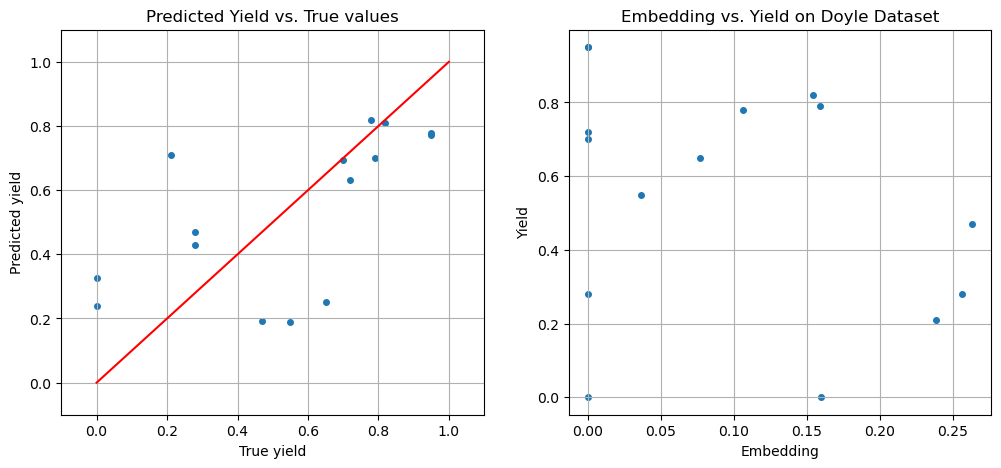

In [66]:
embeddings = get_embedding_from_smi(data_doyle.smiles.to_list(), data_doyle.aroma_c_index.to_list(), model_pretrained, device)
y = data_doyle['label'].values
X = embeddings

np.random.seed(8)
random.seed(8)

n_feat = 3
n_neighbors = 4
loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mut_info = mutual_info_regression(X_train, y_train)
    X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
    X_train.reshape(-1, n_feat)
    X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
    X_test.reshape(-1, n_feat)

    # reg = Lasso(alpha=1.0)
    # reg = LinearRegression()
    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform', metric='cosine')
    # reg = SVR(kernel='rbf', C=1e3, gamma=0.1)
    # reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=5)
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    if y_pred[0] > 1:
        y_pred[0] = 1
    if y_pred[0] < 0:
        y_pred[0] = 0
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
# print("Mutual information: ", mut_info)

# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([0, 1], [0, 1], c='r')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel("True yield")
ax1.set_ylabel("Predicted yield")
ax1.set_title("Predicted Yield vs. True values")
ax1.grid()

ax2.scatter(X[:, 0], y, s=16)
ax2.set_xlabel("Embedding")
ax2.set_ylabel("Yield")
ax2.set_title("Embedding vs. Yield on Doyle Dataset")
ax2.grid()

plt.show()

In [13]:
import autosklearn.regression
reg = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=60,
    per_run_time_limit=5,
    n_jobs=-1,
    memory_limit=30720,
)

reg.fit(X, y)
predictions = reg.predict(X)
r2_score(y, predictions)

0.7978868893353719

In [17]:
y = data_doyle['label'].values
X = embeddings

import autosklearn.regression
reg = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=60,
    per_run_time_limit=5,
    n_jobs=-1,
    memory_limit=30720,
)

reg.fit(X, y)
predictions = reg.predict(X)
r2_score(y, predictions)

[WARNING] [2023-08-07 15:17:14,639:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1


0.2885620538754248

In [16]:
y = data_doyle['label'].values
X = embeddings

loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    predictor = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=60,
        per_run_time_limit=5,
        n_jobs=-1,
        memory_limit=30720,
    )
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    if y_pred[0] > 1:
        y_pred[0] = 1
    if y_pred[0] < 0:
        y_pred[0] = 0
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
print("Mutual information: ", mut_info)

# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([0, 1], [0, 1], c='r')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel("True yield")
ax1.set_ylabel("Predicted yield")
ax1.set_title("Predicted Yield vs. True values")
ax1.grid()

ax2.scatter(X[:, 0], y, s=16)
ax2.set_xlabel("Embedding")
ax2.set_ylabel("Yield")
ax2.set_title("Embedding vs. Yield on Doyle Dataset")
ax2.grid()

plt.show()

[WARNING] [2023-08-07 15:12:37,654:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-08-07 15:14:08,464:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-08-07 15:15:29,051:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-08-07 15:15:29,279:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-08-07 15:15:29,559:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-08-07 15:15:29,806:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WAR

KeyboardInterrupt: 

R2 score:  -0.1478918045851758
Mutual information:  0.1669326969326974


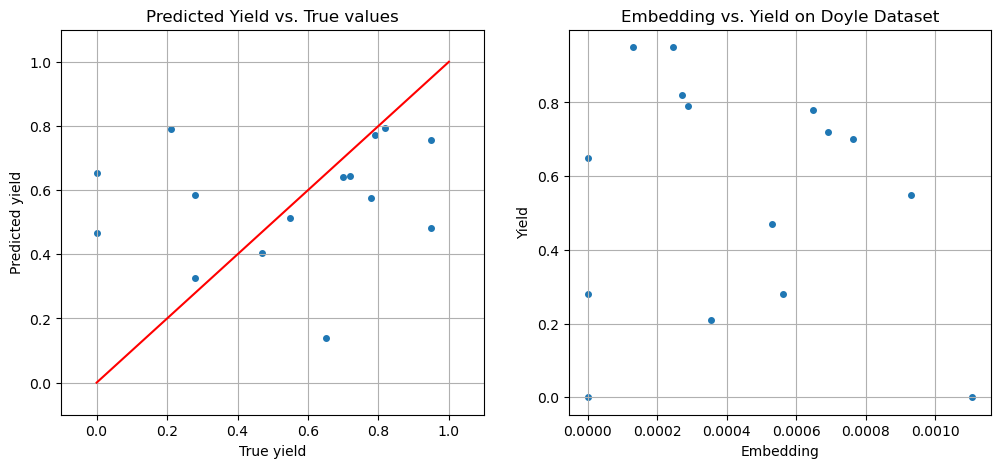

In [30]:
model = model_untrained
model.eval()
if model.pool_method == 'c':
    test_doyle_loader = DataLoader(test_doyle_dataset_c, 64, shuffle=False)
elif model.pool_method == 'cx':
    test_doyle_loader = DataLoader(test_doyle_dataset_cx, 64, shuffle=False)
else:
    raise ValueError('Invalid pool_method type')

embeddings = get_embedding(model, test_doyle_loader, device)
y = data_doyle['label'].values
mut_info = mutual_info_regression(embeddings, y)
# X = embeddings[:, np.argmax(mut_info)]
X = embeddings[:, np.argsort(mut_info)[::-1][:1]]
X.reshape(-1, 3)
mut_info = mut_info.max()
loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # reg = Lasso(alpha=1.0)
    # reg = LinearRegression()
    reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='l1')
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    if y_pred[0] > 1:
        y_pred[0] = 1
    if y_pred[0] < 0:
        y_pred[0] = 0
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
print("Mutual information: ", mut_info)

# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([0, 1], [0, 1], c='r')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel("True yield")
ax1.set_ylabel("Predicted yield")
ax1.set_title("Predicted Yield vs. True values")
ax1.grid()

ax2.scatter(X[:, 0], y, s=16)
ax2.set_xlabel("Embedding")
ax2.set_ylabel("Yield")
ax2.set_title("Embedding vs. Yield on Doyle Dataset")
ax2.grid()

plt.show()

In [205]:
from tdc.chem_utils import MolConvert
smi2rdkit_desc = MolConvert(src = 'SMILES', dst = 'RDKit2D')
smi2morgan = MolConvert(src = 'SMILES', dst = 'Morgan')

R2 score:  -0.3969376333859147
Mutual information:  0.10796536796536782


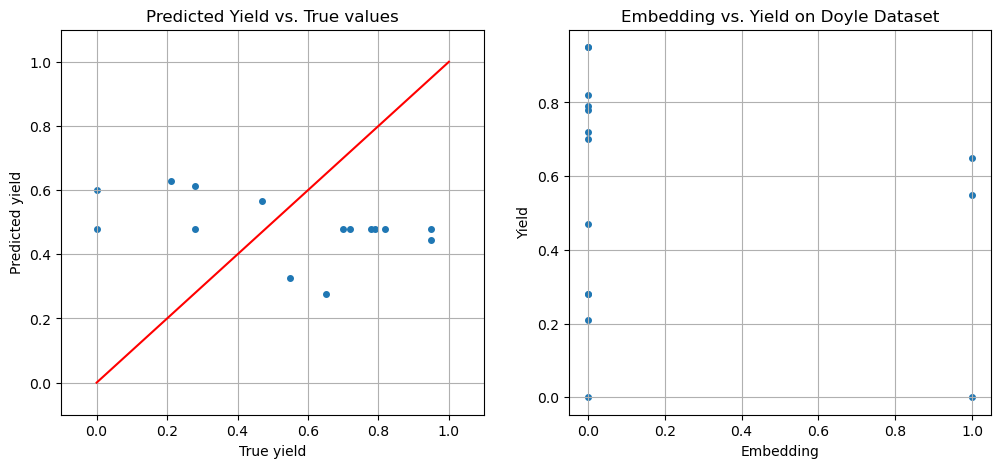

In [215]:
embeddings = smi2morgan(data_doyle.smiles.to_list())
y = data_doyle['label'].values
mut_info = mutual_info_regression(embeddings, y)
# X = embeddings[:, np.argmax(mut_info)]
X = embeddings[:, np.argsort(mut_info)[::-1][:1]]
X.reshape(-1, 3)
mut_info = mut_info.max()
loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # reg = Lasso(alpha=1.0)
    # reg = LinearRegression()
    reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='l1')
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    if y_pred[0] > 1:
        y_pred[0] = 1
    if y_pred[0] < 0:
        y_pred[0] = 0
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
print("Mutual information: ", mut_info)

# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([0, 1], [0, 1], c='r')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel("True yield")
ax1.set_ylabel("Predicted yield")
ax1.set_title("Predicted Yield vs. True values")
ax1.grid()

ax2.scatter(X[:, 0], y, s=16)
ax2.set_xlabel("Embedding")
ax2.set_ylabel("Yield")
ax2.set_title("Embedding vs. Yield on Doyle Dataset")
ax2.grid()

plt.show()

# Another dataset

In [18]:
# https://pubs.acs.org/doi/10.1021/jacs.7b06340
test_smiles = [
    "C1=CC=CC(Cl)=C1I",
    "C1C=C(C(F)(F)F)C=C(Cl)C=1I",
    "C1C=C(C#N)C=C(C(F)(F)F)C=1I",
    "C1C(I)=CC=CC=1C#N",
    "C1C=C(C(=O)OC)C=CC=1I",
    "C1C(I)=CC=C(C(C)=O)C=1",
    "C(I)1=CC=CC2=CC=CC=C12",
    "C1=CC=CC(C(C)C)=C1I",
    "C1C(I)=CC(C)=CC=1C",
    "C1C=C(C)C=CC=1I",
    "C1C(I)=CC=C(OC)C=1",
    "C1C(OC)=C(OC)C(OC)=CC=1I",
    "C1=C2OCOC2=CC=C1I",
    "C1=CC(SC)=CC=C1I",
    "C1=C(I)C=C(OCC2=CC=CC=C2)C(OC)=C1",
]

test_yields = [
    0.72,
    0.62,
    0.61,
    0.70,
    0.61,
    0.60,
    0.58,
    0.66,
    0.69,
    0.69,
    0.56,
    0.59,
    0.66,
    0.60,
    0.46,
]

patt_aryl_halide = Chem.MolFromSmarts('c-[I]')
temp = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in test_smiles]

data_test = pd.DataFrame({
    "smiles": test_smiles,
    "label": test_yields,
    "aroma_c_index": [_[0] for _ in temp],
    "halide_index": [_[1] for _ in temp]
})

embeddings = get_embedding_from_smi(data_test.smiles.to_list(), data_test.aroma_c_index.to_list(), model_pretrained, device)

In [40]:
# https://pubs.acs.org/doi/full/10.1021/jacs.8b03744?src=getftr
# 0.27
test_smiles = [
    "C(Br)1=CC=CC(C(F)(F)F)=C1",
    "C1=C(F)C=C(F)C=C1Br",
    "C1C(Br)=CC=C(F)C=1",
    "C(Cl)1=CC=CC(=C1)Br",
    "C1C=C(Br)C=CC=1",
    "C1C=C(I)C=CC=1",
    "C1C(C(=O)N)=CC=C(Br)C=1",
    "C1C=C(Br)C=CC=1C",
    "C1C(OC)=CC=C(Br)C=1",
    "C1C(OC)=CC=C(I)C=1",
    "C1C(Br)=CC=CC=1OC",
    "C1C(OC)=CC(OC)=CC=1Br",
    "C1C(Br)=CC=C(C#N)C=1",
    "C1C=C(C(=O)OC)C=CC=1Br",
    "C1C(Br)=CC=C(C(C)=O)C=1",
    "C1=CC=NC=C1Br",
    "C1=CC=NC=C1I",
    "C1C(Br)=CN=CN=1"
]

test_yields = [
    0.57,
    0.71,
    0.38,
    0.83,
    0.53,
    0.66,
    0.27,
    0.33,
    0.07,
    0.26,
    0.59,
    0.53,
    0.86,
    0.65,
    0.42,
    0.36,
    0.47,
    0.21
]

patt_aryl_halide = Chem.MolFromSmarts('c-[Br,I]')
temp = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in test_smiles]

data_test = pd.DataFrame({
    "smiles": test_smiles,
    "label": test_yields,
    "aroma_c_index": [_[0] for _ in temp],
    "halide_index": [_[1] for _ in temp]
})

embeddings = get_embedding_from_smi(data_test.smiles.to_list(), data_test.aroma_c_index.to_list(), model_pretrained, device)

In [41]:
import autosklearn.regression
auto_reg = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=60,
    per_run_time_limit=5,
    n_jobs=-1,
    memory_limit=30720,
)

y = data_test['label'].values
X = embeddings

auto_reg.fit(X, y)
predictions = auto_reg.predict(X)
print(r2_score(y, predictions))
print(auto_reg.sprint_statistics())
print(auto_reg.leaderboard())
print(auto_reg.show_models())

[WARNING] [2023-08-07 16:00:43,859:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
0.8565565076313748
auto-sklearn results:
  Dataset name: 11ee1f5f-355d-11ee-ae31-04421af02465
  Metric: r2
  Best validation score: 0.441811
  Number of target algorithm runs: 50
  Number of successful target algorithm runs: 38
  Number of crashed target algorithm runs: 12
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0

          rank  ensemble_weight               type      cost  duration
model_id                                                              
47           1             0.06           adaboost  0.558189  0.717022
17           2             0.46  gradient_boosting  0.582128  3.155664
7            3             0.48   gaussian_process  0.585344  0.802054
{7: {'model_id': 7, 'rank': 1, 'cost': 0.5853443261664709, 'ensemble_weight': 

In [53]:
import autosklearn.regression
auto_reg = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=60,
    per_run_time_limit=5,
    n_jobs=-1,
    memory_limit=30720,
)

y = data_test['label'].values
mut_info = mutual_info_regression(embeddings, y)
X = embeddings[:, np.argsort(mut_info)[::-1][:1]]
X.reshape(-1, 1)

auto_reg.fit(X, y)
predictions = auto_reg.predict(X)
print(r2_score(y, predictions))
print(auto_reg.sprint_statistics())
print(auto_reg.leaderboard())
print(auto_reg.show_models())

0.5554825418570097
auto-sklearn results:
  Dataset name: af223c55-355f-11ee-ae31-04421af02465
  Metric: r2
  Best validation score: 0.226444
  Number of target algorithm runs: 47
  Number of successful target algorithm runs: 34
  Number of crashed target algorithm runs: 13
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0

          rank  ensemble_weight                 type      cost  duration
model_id                                                                
34           1             0.36  k_nearest_neighbors  0.773556  0.526792
45           2             0.22     gaussian_process  0.836722  0.480275
48           3             0.42             adaboost  0.887144  0.463708
{34: {'model_id': 34, 'rank': 1, 'cost': 0.7735559142978757, 'ensemble_weight': 0.36, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f12acb45430>, 'feature_preprocessor': <

R2 score:  0.2731994314189292
Mutual information:  0.16764310489800738


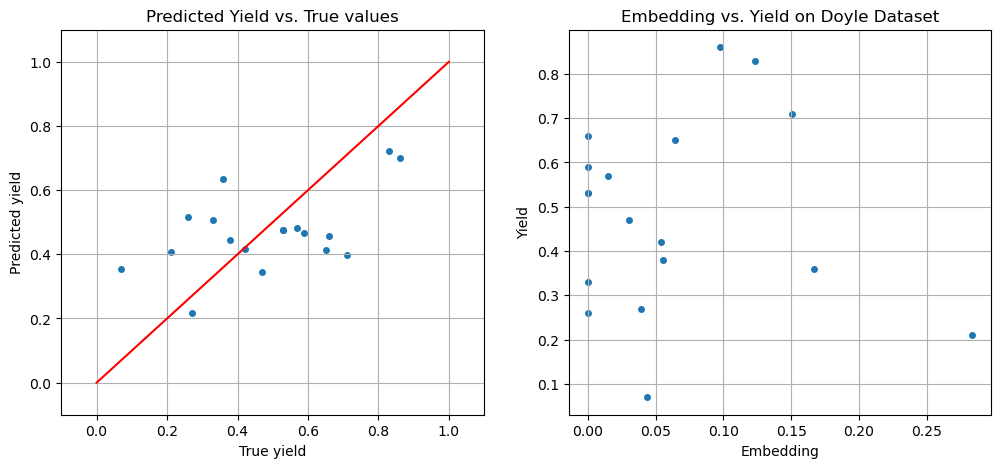

In [61]:
y = data_test['label'].values

mut_info = mutual_info_regression(embeddings, y)
X = embeddings[:, np.argsort(mut_info)[::-1][:1]]
X.reshape(-1, 1)
mut_info = mut_info.max()

# X = embeddings

# f_test, _ = f_regression(embeddings, y)
# X = embeddings[:, np.argsort(f_test)[::-1][:1]]
# X = X.reshape(-1, 1)
# mut_info = f_test.max()

loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # reg = Lasso(alpha=1.0)
    # reg = LinearRegression()
    # reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='l1')
    # reg = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0)
    # reg = SVR(kernel='rbf', C=1.0, epsilon=0.2)
    # reg = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=0)
    reg = GradientBoostingRegressor(n_estimators=10, max_depth=10, random_state=0)
    # reg = ExtraTreesRegressor(max_features=0.5120356089629183, min_samples_split=4, n_estimators=512, n_jobs=1, random_state=1, warm_start=True)
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    if y_pred[0] > 1:
        y_pred[0] = 1
    if y_pred[0] < 0:
        y_pred[0] = 0
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
print("Mutual information: ", mut_info)

# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([0, 1], [0, 1], c='r')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel("True yield")
ax1.set_ylabel("Predicted yield")
ax1.set_title("Predicted Yield vs. True values")
ax1.grid()

ax2.scatter(X[:, 0], y, s=16)
ax2.set_xlabel("Embedding")
ax2.set_ylabel("Yield")
ax2.set_title("Embedding vs. Yield on Doyle Dataset")
ax2.grid()

plt.show()

In [62]:
y = data_test['label'].values
mut_info = mutual_info_regression(embeddings, y)
X = embeddings[:, np.argsort(mut_info)[::-1][:2]]
X.reshape(-1, 2)
mut_info = mut_info.max()

for n_e in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    for m_d in [5, 10, 15, 20]:
        loo = LeaveOneOut()
        ys_pred = []
        ys_true = []

        for i, (train_index, test_index) in enumerate(loo.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            reg = GradientBoostingRegressor(n_estimators=n_e, max_depth=m_d, random_state=0)
            predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
            predictor.fit(X_train, y_train)
            y_pred = predictor.predict(X_test)
            if y_pred[0] > 1:
                y_pred[0] = 1
            if y_pred[0] < 0:
                y_pred[0] = 0
            ys_pred.append(y_pred[0])
            ys_true.append(y_test[0])

        print(f"num_neighbor: {n_e}, max depth: {m_d}, R2 score: {r2_score(ys_true, ys_pred):.3f}")

num_neighbor: 5, max depth: 5, R2 score: 0.154
num_neighbor: 5, max depth: 10, R2 score: 0.144
num_neighbor: 5, max depth: 15, R2 score: 0.144
num_neighbor: 5, max depth: 20, R2 score: 0.144
num_neighbor: 10, max depth: 5, R2 score: 0.156
num_neighbor: 10, max depth: 10, R2 score: 0.158
num_neighbor: 10, max depth: 15, R2 score: 0.158
num_neighbor: 10, max depth: 20, R2 score: 0.158
num_neighbor: 15, max depth: 5, R2 score: 0.099
num_neighbor: 15, max depth: 10, R2 score: 0.091
num_neighbor: 15, max depth: 15, R2 score: 0.091
num_neighbor: 15, max depth: 20, R2 score: 0.091
num_neighbor: 20, max depth: 5, R2 score: 0.046
num_neighbor: 20, max depth: 10, R2 score: 0.038
num_neighbor: 20, max depth: 15, R2 score: 0.038
num_neighbor: 20, max depth: 20, R2 score: 0.038
num_neighbor: 25, max depth: 5, R2 score: 0.007
num_neighbor: 25, max depth: 10, R2 score: 0.001
num_neighbor: 25, max depth: 15, R2 score: 0.001
num_neighbor: 25, max depth: 20, R2 score: 0.001
num_neighbor: 30, max depth: 

In [132]:
smi = "C1C(Br)=C(Cl)N=CC=1C(F)(F)F"
# patt_aryl_halide = Chem.MolFromSmarts('c-[Br]')
patt_aryl_halide = Chem.MolFromSmarts('c-[Cl]')
Chem.MolFromSmiles(smi).GetSubstructMatches(patt_aryl_halide)

((3, 4),)

In [135]:
# https://pubs.acs.org/doi/full/10.1021/jacs.7b05409
test_smiles = [
    "C1=C(Br)C=NC(Cl)=C1",
    "C1=C(Br)C=NC(Cl)=C1",
    "C1C(OC)=C(Cl)N=CC=1Br",
    "C1C(OC)=C(Cl)N=CC=1Br",
    "C1C(Br)=CN=C(Cl)C=1F",
    "C1C(Br)=CN=C(Cl)C=1F",
    "C1C(C#N)=C(Cl)N=CC=1Br",
    "C1C(Br)=CN=C(Cl)C=1C",
    "C1C(Br)=CN=C(Cl)C=1C",
    "C1C(C(F)(F)F)=C(Cl)N=CC=1Br",
    "C1C(C(F)(F)F)=C(Cl)N=CC=1Br",
    "C(C)1C(Br)=CN=C(Cl)C=1",
    "C(C)1C(Br)=CN=C(Cl)C=1",
    "C1C=C(Cl)N=C(C)C=1Br",
    "C1C=C(Cl)N=C(C)C=1Br",
    "C(Cl)1C(Br)=CN=C(Cl)C=1",
    "C(Cl)1C(Br)=CN=C(Cl)C=1",
    "C(Cl)1C(Br)=CN=C(Cl)C=1",
    "C1C=C(Cl)N=C(Cl)C=1Br",
    "C1C=C(Cl)N=C(Cl)C=1Br",
    "C1C=C(Cl)N=C(Cl)C=1Br",
    "C1C(Br)=C(Cl)N=CC=1",
    "C1C(Br)=C(Cl)N=CC=1",
    "C1C(C)=CN=C(Cl)C=1Br",
    "C1C(C)=CN=C(Cl)C=1Br",
    "C1C(Br)=C(Cl)N=CC=1C(F)(F)F",
    "C1C(Br)=C(Cl)N=CC=1C(F)(F)F",
    "C1C(Cl)=CN=C(Cl)C=1Br",
    "C1C(Cl)=CN=C(Cl)C=1Br",
    "C1C(Cl)=CN=C(Cl)C=1Br",
    "C1C(Br)=C(Cl)N=CC=1C#N",
    "C(C)1C=CN=C(Cl)C=1Br",
    "C(C)1C=CN=C(Cl)C=1Br",
    "C1C(Br)=C(Cl)N=C(C)C=1",
    "C1C(Br)=C(Cl)N=C(C)C=1",
    "C1C(Br)=CN=C(Cl)C=1Br",
    "C1C(Br)=CN=C(Cl)C=1Br",
    "C1C(Br)=CN=C(Cl)C=1Br",
]
    
test_c_i = [
    5,
    1,
    4,
    8,
    5,
    1,
    4,
    5,
    1,
    6,
    10,
    6,
    2,
    2,
    7,
    6,
    0,
    2,
    7,
    5,
    2,
    3,
    1,
    5,
    7,
    3,
    1,
    1,
    5,
    7,
    3,
    5,
    7,
    3,
    1,
    5,
    1,
    7,
]

test_yields = [
    0.94,
    0.00,
    0.85,
    0.00,
    0.82,
    0.00,
    0.46,
    0.71,
    0.08,
    0.25,
    0.14,
    0.97,
    0.00,
    0.99,
    0.00,
    0.99,
    0.00,
    0.00,
    0.22,
    0.50,
    0.27,
    0.63,
    0.03,
    0.42,
    0.05,
    0.40,
    0.05,
    0.00,
    0.47,
    0.13,
    0.36,
    0.84,
    0.00,
    0.58,
    0.04,
    0.42,
    0.11,
    0.08,
]

data = pd.DataFrame({
    'smiles': test_smiles,
    'c_index': test_c_i,
    'label': test_yields
})
embeddings = get_embedding_from_smi(data.smiles.to_list(), data.c_index.to_list(), model_pretrained, device)

In [136]:
data

,smiles,c_index,label
0,C1=C(Br)C=NC(Cl)=C1,5,0.94
1,C1=C(Br)C=NC(Cl)=C1,1,0.00
2,C1C(OC)=C(Cl)N=CC=1Br,4,0.85
3,C1C(OC)=C(Cl)N=CC=1Br,8,0.00
4,C1C(Br)=CN=C(Cl)C=1F,5,0.82
5,C1C(Br)=CN=C(Cl)C=1F,1,0.00
6,C1C(C#N)=C(Cl)N=CC=1Br,4,0.46
7,C1C(Br)=CN=C(Cl)C=1C,5,0.71
8,C1C(Br)=CN=C(Cl)C=1C,1,0.08
9,C1C(C(F)(F)F)=C(Cl)N=CC=1Br,6,0.25


In [137]:
smi_list = ["C1C(Br)=C(Cl)N=CC=1", "C1C(C)=CN=C(Cl)C=1Br", "C1C(Br)=C(Cl)N=CC=1C(F)(F)F", "C1C(Cl)=CN=C(Cl)C=1Br", "C1C(Br)=CN=C(Cl)C=1Br"]
data_test = data[data.smiles.isin(smi_list)]
data_train = data[~data.smiles.isin(smi_list)]

In [138]:
embeddings_train = get_embedding_from_smi(data_train.smiles.to_list(), data_train.c_index.to_list(), model_pretrained, device)
embeddings_test = get_embedding_from_smi(data_test.smiles.to_list(), data_test.c_index.to_list(), model_pretrained, device)

In [139]:
import autosklearn.regression
auto_reg = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=60,
    per_run_time_limit=5,
    n_jobs=-1,
    memory_limit=30720,
)

y_train = data_train['label'].values
y_test = data_test['label'].values
mut_info = mutual_info_regression(embeddings_train, y_train)
# X_train = embeddings_train[:, np.argsort(mut_info)[::-1][:2]]
# X_train.reshape(-1, 2)
X_train = embeddings_train
# X_test = embeddings_test[:, np.argsort(mut_info)[::-1][:2]]
# X_test.reshape(-1, 2)
X_test = embeddings_test

auto_reg.fit(X_train, y_train)
y_pred = auto_reg.predict(X_test)
print(r2_score(y_test, y_pred))
print(auto_reg.sprint_statistics())
print(auto_reg.leaderboard())
print(auto_reg.show_models())

0.36386399813771275
auto-sklearn results:
  Dataset name: 1355666c-358a-11ee-ae31-04421af02465
  Metric: r2
  Best validation score: 0.583879
  Number of target algorithm runs: 40
  Number of successful target algorithm runs: 37
  Number of crashed target algorithm runs: 2
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0

          rank  ensemble_weight               type      cost  duration
model_id                                                              
15           1             0.86        extra_trees  0.416121  1.083355
16           2             0.14  gradient_boosting  0.605065  0.972617
{15: {'model_id': 15, 'rank': 1, 'cost': 0.4161210699948563, 'ensemble_weight': 0.86, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f0bbc064100>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice o

In [140]:
data_test['pred'] = y_pred
data_test

/home/whgao/tmp/ipykernel_2534961/403907028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pred'] = y_pred


,smiles,c_index,label,pred
21,C1C(Br)=C(Cl)N=CC=1,3,0.63,0.418692
22,C1C(Br)=C(Cl)N=CC=1,1,0.03,0.098476
23,C1C(C)=CN=C(Cl)C=1Br,5,0.42,0.303053
24,C1C(C)=CN=C(Cl)C=1Br,7,0.05,0.050824
25,C1C(Br)=C(Cl)N=CC=1C(F)(F)F,3,0.40,0.561411
26,C1C(Br)=C(Cl)N=CC=1C(F)(F)F,1,0.05,0.250564
27,C1C(Cl)=CN=C(Cl)C=1Br,1,0.00,0.377514
28,C1C(Cl)=CN=C(Cl)C=1Br,5,0.47,0.601042
29,C1C(Cl)=CN=C(Cl)C=1Br,7,0.13,0.232015
35,C1C(Br)=CN=C(Cl)C=1Br,5,0.42,0.349508


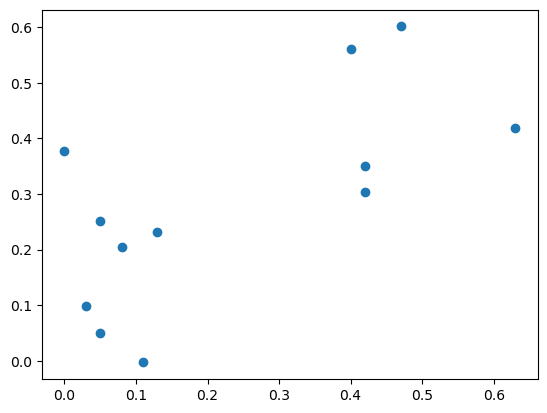

In [141]:
plt.scatter(y_test, y_pred)
plt.show()

In [ ]:
y = data_test['label'].values

mut_info = mutual_info_regression(embeddings, y)
X = embeddings[:, np.argsort(mut_info)[::-1][:1]]
X.reshape(-1, 1)
mut_info = mut_info.max()

# X = embeddings

# f_test, _ = f_regression(embeddings, y)
# X = embeddings[:, np.argsort(f_test)[::-1][:1]]
# X = X.reshape(-1, 1)
# mut_info = f_test.max()

loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # reg = Lasso(alpha=1.0)
    # reg = LinearRegression()
    # reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='l1')
    # reg = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0)
    # reg = SVR(kernel='rbf', C=1.0, epsilon=0.2)
    # reg = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=0)
    # reg = GradientBoostingRegressor(n_estimators=10, max_depth=10, random_state=0)
    # reg = ExtraTreesRegressor(max_features=0.5120356089629183, min_samples_split=4, n_estimators=512, n_jobs=1, random_state=1, warm_start=True)
    reg = 
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    if y_pred[0] > 1:
        y_pred[0] = 1
    if y_pred[0] < 0:
        y_pred[0] = 0
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
print("Mutual information: ", mut_info)

# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([0, 1], [0, 1], c='r')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel("True yield")
ax1.set_ylabel("Predicted yield")
ax1.set_title("Predicted Yield vs. True values")
ax1.grid()

ax2.scatter(X[:, 0], y, s=16)
ax2.set_xlabel("Embedding")
ax2.set_ylabel("Yield")
ax2.set_title("Embedding vs. Yield on Doyle Dataset")
ax2.grid()

plt.show()

# Hammett constant

In [31]:
data = pd.read_csv(os.path.join(HOME_DIR, "data/Hammett.csv"))

patt_aryl_halide = Chem.MolFromSmarts('c-[Br]')
cx_indices = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in data.SMILES]

if config.pool == 'c':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind], 
                                                atm_idx=[cx_indices[ind][0]]) for ind in range(len(data))]
elif config.pool == 'cx':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind], 
                                            atm_idx=[cx_indices[ind][0], cx_indices[ind][1]]) for ind in range(len(data))]
elif config.pool == 'global':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind]) for ind in range(len(data))]
else:
    raise ValueError('Invalid pool type')
loader = DataLoader(train_dataset, 128, shuffle=False)

embeddings_pretrained = get_embedding(model_pretrained, loader, device)
embeddings_untrained = get_embedding(model_untrained, loader, device)

R2 score:  0.4037119329569685
Mutual information:  0.19772333486291194


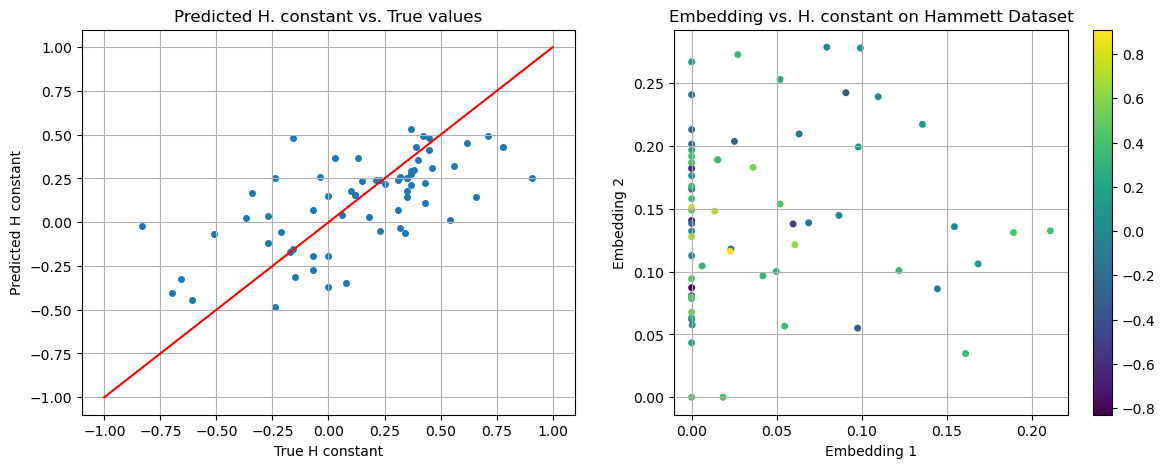

In [117]:
y = data['constant'].values
mut_info = mutual_info_regression(embeddings_pretrained, y)
# from embedding pick the top 3 features with highest mutual information
X = embeddings_pretrained[:, np.argsort(mut_info)[::-1][:4]]
loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # reg = Lasso(alpha=1e-2)
    # reg = LinearRegression() # 4, 0.211
    # reg = SVR(kernel='poly', C=1e4, gamma=0.1)
    reg = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=15) # 5, 0.408
    # reg = KNeighborsRegressor(n_neighbors=6, weights='distance', metric='l2') # 4, 0.345
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
print("Mutual information: ", mut_info.max())

# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([-1, 1], [-1, 1], c='r')
# ax1.set_xlim(-0.1, 1.1)
# ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel("True H constant")
ax1.set_ylabel("Predicted H constant")
ax1.set_title("Predicted H. constant vs. True values")
ax1.grid()

im = ax2.scatter(X[:, 0], X[:, 1], s=16, c=y)
ax2.set_xlabel("Embedding 1")
ax2.set_ylabel("Embedding 2")
ax2.set_title("Embedding vs. H. constant on Hammett Dataset")
ax2.grid()

plt.colorbar(im, ax=ax2)
plt.show()

In [25]:
for md in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    for n_e in [5, 10, 15, 20, 25, 30, 35, 40]:

        for i, (train_index, test_index) in enumerate(loo.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # reg = Lasso(alpha=1.0)
            # reg = LinearRegression()
            # reg = SVR(kernel='rbf', C=1e3, gamma=0.1)
            reg = RandomForestRegressor(max_depth=md, random_state=0, n_estimators=n_e)
            # reg = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='l2')
            predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
            predictor.fit(X_train, y_train)
            y_pred = predictor.predict(X_test)
            ys_pred.append(y_pred[0])
            ys_true.append(y_test[0])

        print("Max depth: ", md)
        print("Number of estimators: ", n_e)
        print("R2 score: ", r2_score(ys_true, ys_pred))

Max depth:  1
Number of estimators:  5
R2 score:  0.13374466281975617
Max depth:  1
Number of estimators:  10
R2 score:  0.14012908581967043
Max depth:  1
Number of estimators:  15
R2 score:  0.1443433632007649
Max depth:  1
Number of estimators:  20
R2 score:  0.14709207951857928
Max depth:  1
Number of estimators:  25
R2 score:  0.1481678610751933
Max depth:  1
Number of estimators:  30
R2 score:  0.15001556839005692
Max depth:  1
Number of estimators:  35
R2 score:  0.1519942033931041
Max depth:  1
Number of estimators:  40
R2 score:  0.1538791700037394
Max depth:  2
Number of estimators:  5
R2 score:  0.15038851012542165
Max depth:  2
Number of estimators:  10
R2 score:  0.15095093176315566
Max depth:  2
Number of estimators:  15
R2 score:  0.1517431220236758
Max depth:  2
Number of estimators:  20
R2 score:  0.15238156581882212
Max depth:  2
Number of estimators:  25
R2 score:  0.15315737534425566
Max depth:  2
Number of estimators:  30
R2 score:  0.15478658145687008
Max depth:  2

# xTB prediction

In [120]:
data = pd.read_csv(os.path.join(HOME_DIR, "data/Hammett_autoqchem.csv"))

if config.pool == 'c':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind], 
                                                atm_idx=[data['c_index'][ind]]) for ind in range(len(data))]
elif config.pool == 'cx':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind], 
                                            atm_idx=[data['c_index'][ind], data['x_index'][ind]]) for ind in range(len(data))]
elif config.pool == 'global':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind]) for ind in range(len(data))]
else:
    raise ValueError('Invalid pool type')
loader = DataLoader(train_dataset, 128, shuffle=False)

embeddings_pretrained = get_embedding(model_pretrained, loader, device)
embeddings_untrained = get_embedding(model_untrained, loader, device)

In [122]:
data.columns

Index(['SMILES', 'constant', 'position', 'c_index', 'x_index',
       'global_number_of_atoms', 'global_charge', 'global_multiplicity',
       'global_dipole', 'global_molar_mass', 'global_molar_volume',
       'global_electronic_spatial_extent', 'global_E_scf',
       'global_zero_point_correction', 'global_E_thermal_correction',
       'global_H_thermal_correction', 'global_G_thermal_correction',
       'global_E_zpe', 'global_E', 'global_H', 'global_G',
       'global_stoichiometry', 'global_converged', 'global_homo_energy',
       'global_lumo_energy', 'global_electronegativity', 'global_hardness',
       'global_ES_root_dipole', 'global_ES_root_molar_volume',
       'global_ES_root_electronic_spatial_extent', 'local_X', 'local_Y',
       'local_Z', 'local_VBur', 'local_Mulliken_charge', 'local_APT_charge',
       'local_NPA_charge', 'local_NPA_core', 'local_NPA_valence',
       'local_NPA_Rydberg', 'local_NPA_total', 'local_NMR_shift',
       'local_NMR_anisotropy', 'local_ES_root

R2 score:  0.45001291328184
Mutual information:  17.714296131483753


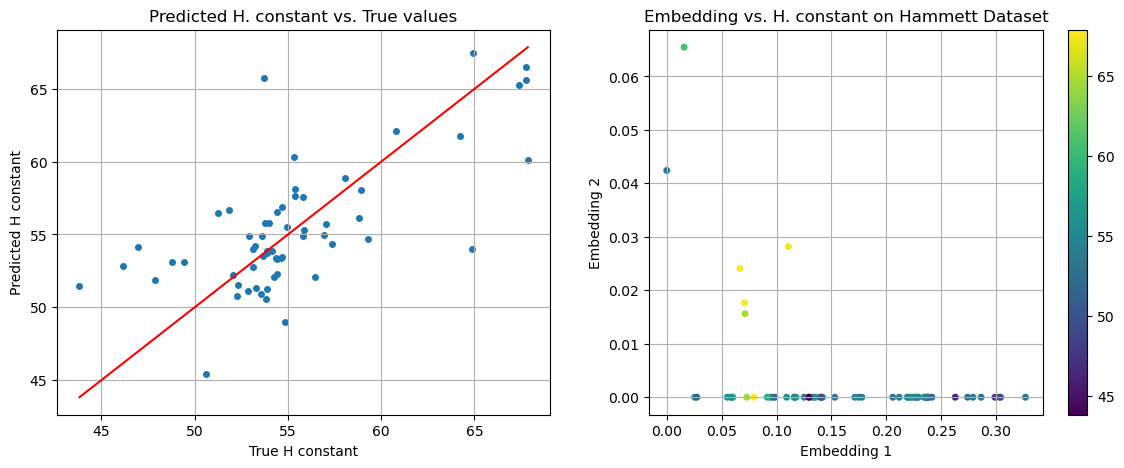

In [204]:
y = data['local_NMR_shift'].values
mut_info = mutual_info_regression(embeddings_pretrained, y)
f_test, _ = f_regression(embeddings_pretrained, y)
# from embedding pick the top 3 features with highest mutual information
X = embeddings_pretrained[:, np.argsort(f_test)[::-1][:2]]
loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # reg = Lasso(alpha=1e-2)
    # reg = LinearRegression() # 4, 0.246
    # reg = SVR(kernel='poly', C=1e4, gamma=0.1)
    # reg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=15) # 5, 0.408
    reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='l1') # 2, f_test, 0.450
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
print("Mutual information: ", f_test.max())

# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], c='r')
ax1.set_xlabel("True H constant")
ax1.set_ylabel("Predicted H constant")
ax1.set_title("Predicted H. constant vs. True values")
ax1.grid()

try:
    im = ax2.scatter(X[:, 0], X[:, 1], s=16, c=y)
except:
    im = ax2.scatter(X[:, 0], y, s=16, c=y)
ax2.set_xlabel("Embedding 1")
ax2.set_ylabel("Embedding 2")
ax2.set_title("Embedding vs. H. constant on Hammett Dataset")
ax2.grid()

plt.colorbar(im, ax=ax2)
plt.show()

R2 score:  0.13842938509356195
Mutual information:  14.325745164492568


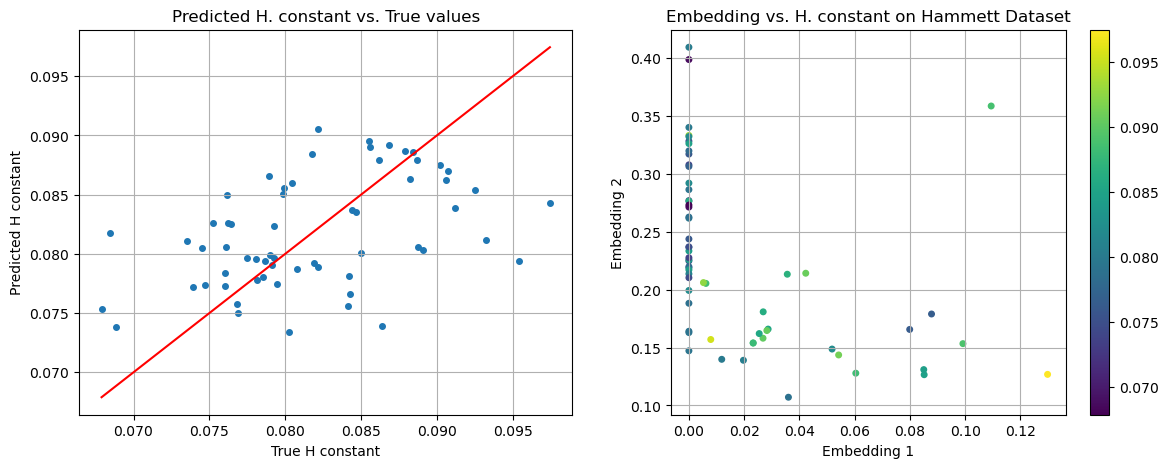

In [216]:
y = data['local_Mulliken_charge'].values
mut_info = mutual_info_regression(embeddings_pretrained, y)
f_test, _ = f_regression(embeddings_pretrained, y)
# from embedding pick the top 3 features with highest mutual information
X = embeddings_pretrained[:, np.argsort(f_test)[::-1][:2]]
loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # reg = Lasso(alpha=1e-2)
    # reg = LinearRegression() # 4, 0.246
    # reg = SVR(kernel='poly', C=1e4, gamma=0.1)
    # reg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=15) # 5, 0.408
    reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='l1') # 2, f_test, 0.450
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
print("Mutual information: ", f_test.max())

# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], c='r')
ax1.set_xlabel("True H constant")
ax1.set_ylabel("Predicted H constant")
ax1.set_title("Predicted H. constant vs. True values")
ax1.grid()

try:
    im = ax2.scatter(X[:, 0], X[:, 1], s=16, c=y)
except:
    im = ax2.scatter(X[:, 0], y, s=16, c=y)
ax2.set_xlabel("Embedding 1")
ax2.set_ylabel("Embedding 2")
ax2.set_title("Embedding vs. H. constant on Hammett Dataset")
ax2.grid()

plt.colorbar(im, ax=ax2)
plt.show()